# Summary of output from model of COVID-19 <a class="anchor" id="home"></a>


### Overview

This Jupyter notebook summarises output from the [OpenABM-Covid19](https://github.com/BDI-pathogens/OpenABM-Covid19) model.  This notebook provides basic plotting functions for a single simulation of the model using a single set of parameters.  The notebook is intended as a guide for how model output may be explored.  The figures in this notebook demonstrate some of the more detailed outputs from the model including 1) the time series output, 2) summary of all simulated SARS-CoV2 transmission events in a simulated epidemic, and 3) and all interaction events between individuals on the last day of the simulated outbreak.  Model output can be generated using this notebook by evaluating the cells below.  Four larger files generated by the model will be written to file in the location specified in the variable `output_dir` below.  These files are: 

1. `individual_file_Run1.csv`: a file of all individuals in the simulated epidemic.  
2. `transmission_Run1.csv`: a file of all transmission events in the simulated epidemic.  
3. `interactions_Run1.csv`: a file of all interaction events on the final day of the simulation.  
4. `trace_tokens_Run1.csv`: a file of all contact tracing events (up to the last 14 days) that have not been released.


The figures in this notebook are not intended to be used as projections of the current COVID19 outbreak.


### Usage

1. Download or clone the [OpenABM-Covid19](https://github.com/BDI-pathogens/OpenABM-Covid19) model.  
2. Install the Python interface for OpenABM-Covid19 (see the README.md for instructions).  
3. Evaluate each of the cells below.  


### Table of contents

*Output from a single simulation*
* [Key parameter values](#parameter-values)
* [Time series](#time-series)
* [Interactions between individuals](#interactions)
* [Transmission network](#transmission-network)
* [Age-stratified outputs](#age-stratified-outputs)


*Notes*

This notebook was generated using the [OpenABM-Covid19](https://github.com/BDI-pathogens/OpenABM-Covid19) codebase 25th May 2020.  

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from os.path import join
from IPython.core.display import display, HTML
import plotting

### Model parameters

In [2]:
from COVID19.model import Model, Parameters, ModelParameterException
import COVID19.simulation as simulation

input_parameter_file = "../tests/data/baseline_parameters.csv"
parameter_line_number = 1
output_dir = "results"
household_demographics_file = "../tests/data/baseline_household_demographics.csv"
hospital_file = "../tests/data/hospital_baseline_parameters.csv"

### Run model

Simulate an epidemic with no interventions for 150 days using a population of 100,000.  

In [3]:
params = Parameters(
    input_parameter_file, 
    parameter_line_number, 
    output_dir, 
    household_demographics_file,
    hospital_file)

T = 150
N = 100000
params.set_param("end_time", T)
params.set_param("n_total", N)

model = simulation.COVID19IBM(model = Model(params))
sim = simulation.Simulation(env = model, end_time = T)
sim.steps(T)

### Read input parameter file

In [4]:
df_parameters = pd.read_csv(input_parameter_file)

# In case any parameter values have been redefined in this Jupyter notebook,
# read parameter values from Parameters object
df_parameters_used = plotting.get_df_from_params(params, df_parameters.columns)

### Write/import output data

In [5]:
df_timeseries = pd.DataFrame(sim.results)

sim.env.model.write_output_files()
df_indiv = pd.read_csv(join(output_dir, "individual_file_Run1.csv"))
df_trans = pd.read_csv(join(output_dir, "transmission_Run1.csv"))
df_interact = pd.read_csv(join(output_dir, "interactions_Run1.csv"))

### Define plotting constants

In [6]:
from COVID19.model import AgeGroupEnum, EVENT_TYPES, TransmissionTypeEnum, OccupationNetworkEnum

interaction_types = [c.value for c in TransmissionTypeEnum ]
interaction_labels = [c.name[1:].title() for c in TransmissionTypeEnum]

occupation_types = [c.value for c in OccupationNetworkEnum ]
occupation_labels = [c.name[1:].title().replace("_", " ") for c in OccupationNetworkEnum ]

AGE_OCCUPATION_MAP = [
    OccupationNetworkEnum._primary_network.value,
    OccupationNetworkEnum._secondary_network.value,
    OccupationNetworkEnum._working_network.value,
    OccupationNetworkEnum._working_network.value,
    OccupationNetworkEnum._working_network.value,
    OccupationNetworkEnum._working_network.value,
    OccupationNetworkEnum._working_network.value,
    OccupationNetworkEnum._retired_network.value,
    OccupationNetworkEnum._elderly_network.value]

infectious_compartments = ["PRESYMPTOMATIC", "PRESYMPTOMATIC_MILD", "ASYMPTOMATIC", "SYMPTOMATIC", "SYMPTOMATIC_MILD"]
infectious_types = [e.value for e in EVENT_TYPES if e.name in infectious_compartments]
infectious_names = [e.name for e in EVENT_TYPES if e.name in infectious_compartments]
infectious_labels = [plotting.EVENT_TYPE_STRING[e.value] for e in EVENT_TYPES if e.name in infectious_compartments]

# Define age groups and labels <- FIXME: change to Enum in constant.py
n_age = len(AgeGroupEnum) + 1
age_group_labels = [enum.name[1:].replace("_","-") for enum in AgeGroupEnum]
age_group_labels[-1] = "80+"

# Key parameter values <a class="anchor" id="parameter-values"></a>
[[Home](#home)]

In [7]:
df_key_params = pd.DataFrame({
    "Parameter name": plotting.key_params,
    "Parameter value": [params.get_param(p) for p in plotting.key_params]
})
display(df_key_params.style.hide_index().set_precision(4))

Parameter name,Parameter value
n_total,100000.0000
n_seed_infection,10.0000
infectious_rate,5.8000
asymptomatic_infectious_factor,0.3300
mild_infectious_factor,0.7200
daily_non_cov_symptoms_rate,0.0020


## Waiting time distributions

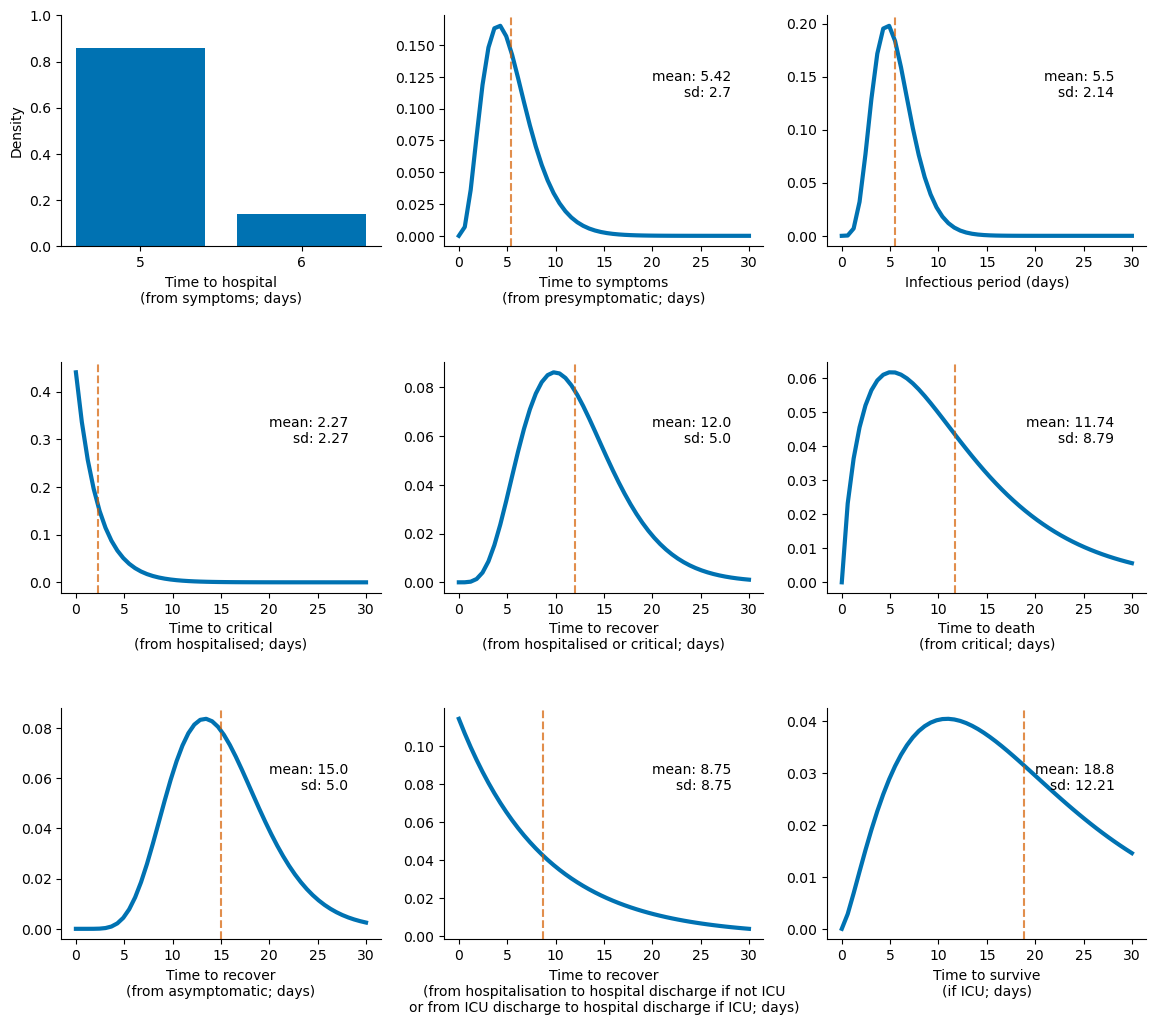

In [8]:
plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plotting.plot_parameter_assumptions(df_parameters_used)

## Age-specific parameters

In [9]:
age_cols = [
    plotting.susceptibility_cols, plotting.asymptomatic_cols,
    plotting.hospitalised_cols, plotting.critical_cols,
    plotting.fatality_cols, plotting.mild_cols,
    plotting.app_users_cols
]

age_params = [[params.get_param(p) for p in cols] for cols in age_cols]
df = pd.DataFrame(age_params); df.columns = age_group_labels
df.rename(index = {0:'Relative susceptibility', 
                   1:'Pr( asymptomatic | infected )',
                   2:'Pr( hospitalisation | symptomatic )',
                   3:'Pr( ICU | hospitalised )',
                   4:'Pr( death | ICU )',
                   5:'Pr( mild | infected )',
                   6:'Pr( app users )'
                  }, inplace = True)
display(df.style.set_precision(2))

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
Relative susceptibility,0.35,0.69,1.03,1.03,1.03,1.03,1.27,1.52,1.52
Pr( asymptomatic | infected ),0.46,0.41,0.37,0.33,0.30,0.27,0.24,0.21,0.19
Pr( hospitalisation | symptomatic ),0.00,0.01,0.01,0.07,0.22,0.28,0.37,0.39,0.38
Pr( ICU | hospitalised ),0.05,0.05,0.05,0.05,0.06,0.12,0.27,0.43,0.71
Pr( death | ICU ),0.33,0.25,0.50,0.50,0.50,0.69,0.65,0.88,1.00
Pr( mild | infected ),0.53,0.57,0.60,0.61,0.62,0.60,0.57,0.52,0.46
Pr( app users ),0.09,0.80,0.97,0.96,0.94,0.86,0.70,0.48,0.32


# Time series <a class="anchor" id="time-series"></a>
[[Home](#home)]

Plot the epidemic trajectory and other outputs from the time series file for a single parameter set.  

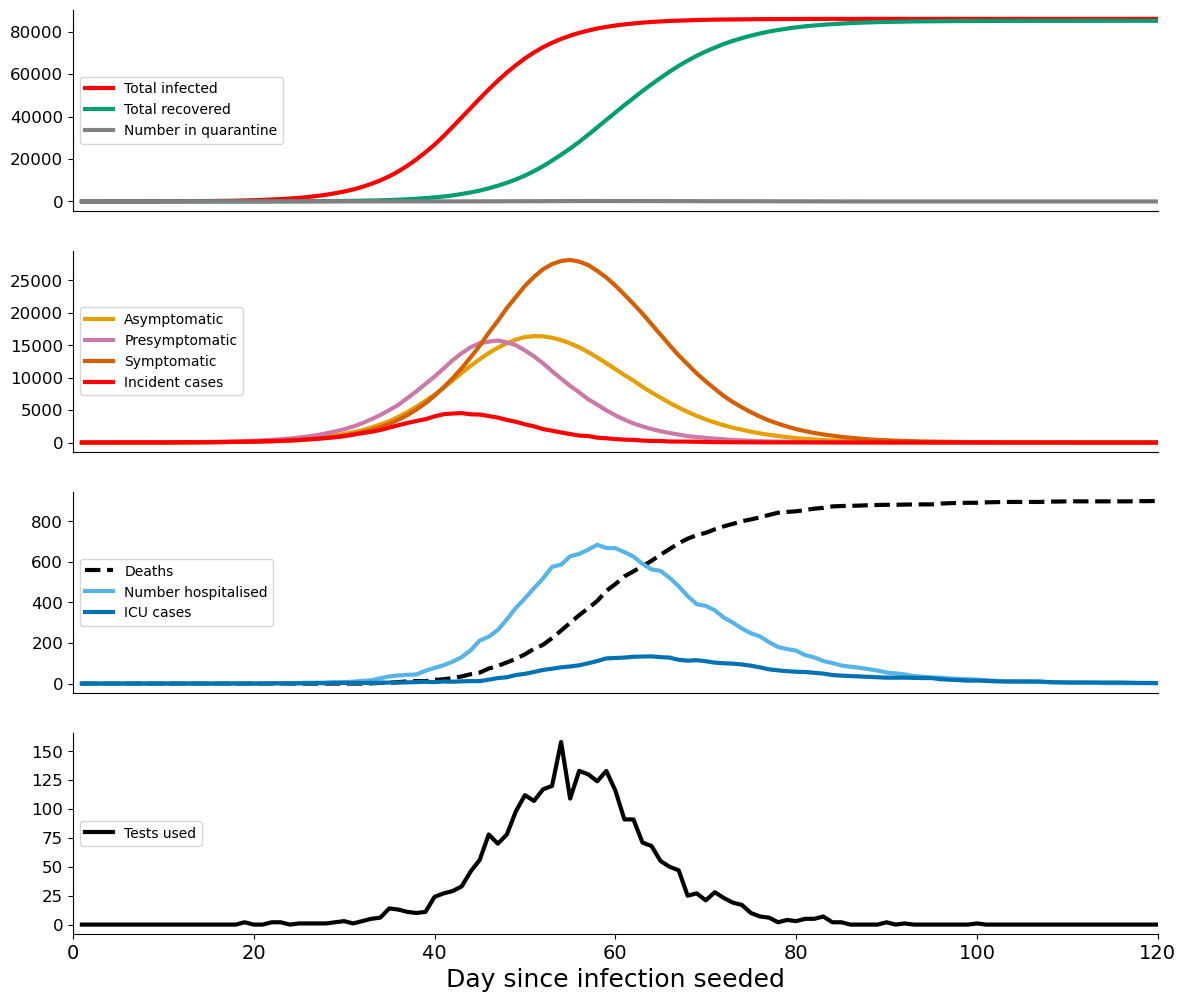

In [10]:
plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plotting.plot_timeseries_curves(df_timeseries, xlimits = [0, 120])

# Interactions <a class="anchor" id="interactions"></a>
[[Home](#home)]

Summaries of interactions in the final day of the simulation.  


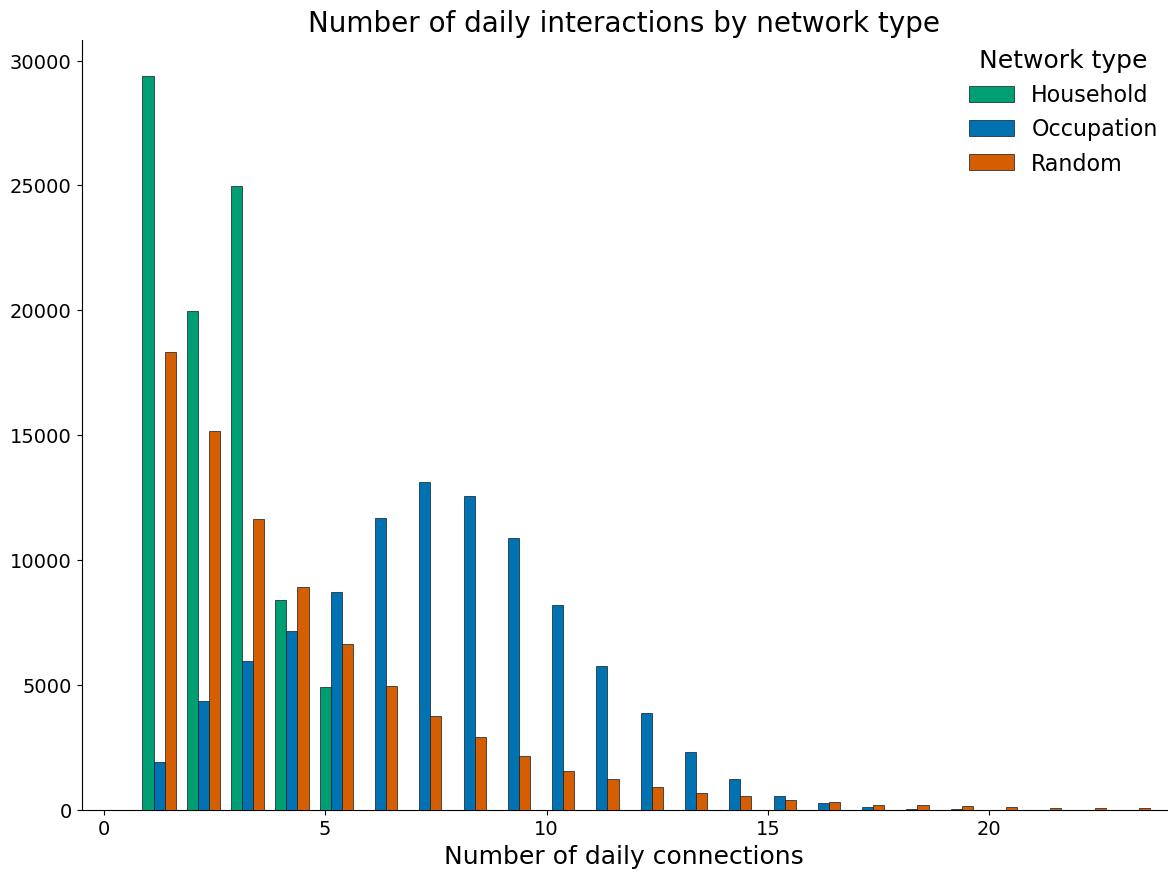

In [11]:
plt.rcParams['figure.figsize'] = [14, 10]
# Count interactions for each individual by "type" of interaction
df_agg = df_interact.groupby(["ID_1", "type"])["ID_1"].count().reset_index(name = "count")

# Plot histogram of interaction by network type
fig, ax = plotting.plot_hist_by_group(df_agg, groupvar = "type", binvar = "count", 
    groups = interaction_types, bins = 25, group_colours = plotting.network_colours, 
    group_labels = interaction_labels, 
    xlabel = "Number of daily connections", 
    title = "Number of daily interactions by network type", 
    legend_title = "Network type")

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


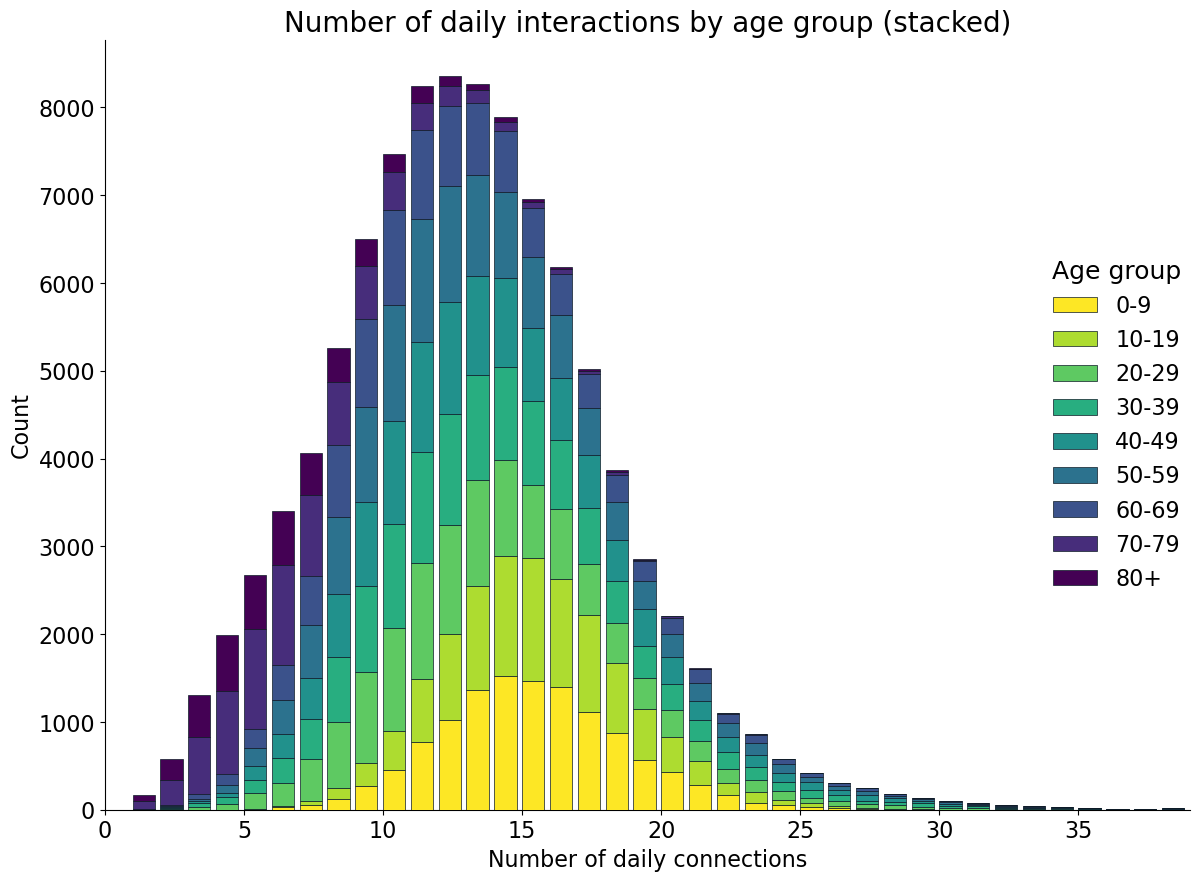

In [12]:
plt.rcParams['figure.figsize'] = [14, 10]
fig, ax = plotting.plot_interactions_by_age(
    df_interact, groupvar = "age_group_1", 
    group_labels = age_group_labels, legend_title = "Age group", 
    title = "Number of daily interactions by age group (stacked)", 
    xlabel = "Number of daily connections", ylabel = "Count")

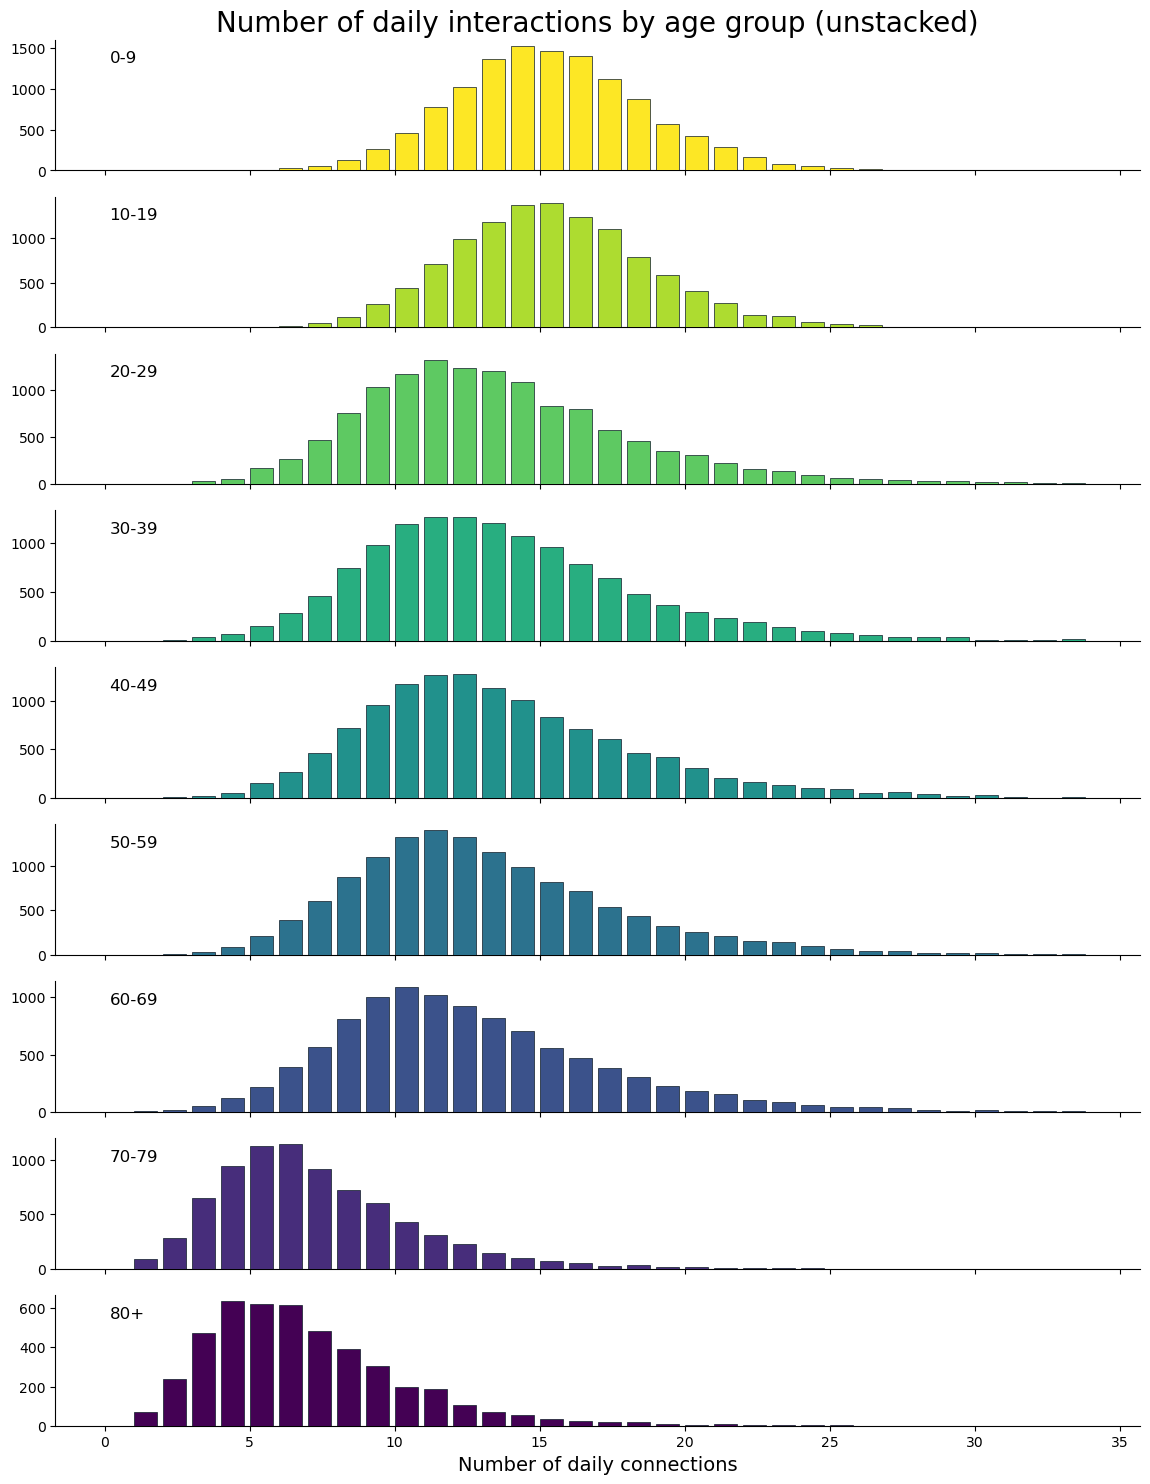

In [13]:
n_groups = len(age_group_labels)
colours = plotting.get_discrete_viridis_colours(n_groups)
NBINS = 35
bins = np.arange(NBINS)
plt.rcParams['figure.figsize'] = [14,18]

df_agg = df_interact.groupby(["age_group_1", "ID_1"]).size().reset_index(name = "counts")

fig, ax = plt.subplots(nrows = n_groups)
for i, age in enumerate(age_group_labels):
    
    # Split by age group
    hist = df_agg.loc[df_agg["age_group_1"] == i].counts
    
    ax[i].hist(hist, bins, label = age_group_labels[i], 
        width = 0.8, color = colours[i], edgecolor = "#0d1a26", 
        linewidth = 0.5, zorder = 3)

    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].set_ylabel("")
    if i == (n_groups - 1):
        ax[i].set_xlabel("Number of daily connections", fontsize = 14)
    else:
        ax[i].set_xlabel("")
        ax[i].set_xticklabels([])
    
    ax[i].text(0.05, 0.8, "{}".format(age_group_labels[i]),
        ha = 'left', va = 'bottom', 
        transform = ax[i].transAxes, fontsize = 12)
    
    if i ==0:
        ax[i].set_title("Number of daily interactions by age group (unstacked)", size = 20)

### Number of interactions by age and network type

In [15]:
interactions = pd.pivot_table(df_interact, index = "age_group_1", columns = "type", aggfunc = 'size', fill_value = 0)
interactions.columns = interaction_labels
interactions["Age group"] = age_group_labels
display(interactions[["Age group"] + interaction_labels].style.hide_index())

Age group,Household,Occupation,Random
0-9,35961,121451,24012
10-19,34166,113144,23059
20-29,27875,92624,52414
30-39,29496,93696,53649
40-49,28735,90017,51132
50-59,23405,94482,53638
60-69,11916,73766,41747
70-79,7581,23182,23775
80+,3195,12746,13758


### Number of interactions stratified by age of both individuals involved and network type

In [16]:
for i, t in enumerate(interaction_types):
    interactions = pd.pivot_table(df_interact.loc[df_interact.type == t], 
        index = "age_group_1", columns = "age_group_2", aggfunc = 'size', fill_value = 0)
    interactions.columns = age_group_labels
    np.fill_diagonal(interactions.values, np.diag(interactions.values)/2)
    interactions["Age group"] = age_group_labels
    
    display(HTML("<hr>"))
    display(HTML("<b>Interactions in the {} network</b>".format(interaction_labels[i])))
    display(HTML("Rows: age group of individual 1 <br>Columns: age group of individual 2"))
    
    interactions = interactions.where(np.triu(np.ones(interactions.shape)).astype(np.bool)).replace(np.nan, "-")
    display(interactions[["Age group"] + age_group_labels].style.hide_index().set_precision(0))

<ipython-input-16-63d67ed72e5f>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  interactions = interactions.where(np.triu(np.ones(interactions.shape)).astype(np.bool)).replace(np.nan, "-")


Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,4079,4950,4970,11078,5200,1044,331,170,60
10-19,-,3319,3137,4567,9520,4309,578,302,165
20-29,-,-,3251,2952,3095,5497,1265,317,140
30-39,-,-,-,2907,2342,1173,1086,383,101
40-49,-,-,-,-,2432,2274,548,680,212
50-59,-,-,-,-,-,2955,2044,582,572
60-69,-,-,-,-,-,-,2135,1484,310
70-79,-,-,-,-,-,-,-,1439,785
80+,-,-,-,-,-,-,-,-,425


<ipython-input-16-63d67ed72e5f>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  interactions = interactions.where(np.triu(np.ones(interactions.shape)).astype(np.bool)).replace(np.nan, "-")


Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,50688,0,4314,4081,4076,4351,3253,0,0
10-19,-,47355,3694,3954,3837,3712,3237,0,0
20-29,-,-,8668,17549,16787,17783,13884,840,437
30-39,-,-,-,8854,17121,18037,13945,866,435
40-49,-,-,-,-,8224,17046,13530,777,395
50-59,-,-,-,-,-,9143,13908,810,549
60-69,-,-,-,-,-,-,5496,605,412
70-79,-,-,-,-,-,-,-,9642,0
80+,-,-,-,-,-,-,-,-,5259


<ipython-input-16-63d67ed72e5f>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  interactions = interactions.where(np.triu(np.ones(interactions.shape)).astype(np.bool)).replace(np.nan, "-")


Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,880,1623,3670,3885,3677,3894,2880,1673,950
10-19,-,784,3510,3744,3513,3713,2834,1596,958
20-29,-,-,4039,8306,7975,8467,6687,3643,2078
30-39,-,-,-,4217,8008,8488,6710,3791,2283
40-49,-,-,-,-,3915,8118,6282,3664,2065
50-59,-,-,-,-,-,4272,6420,3768,2226
60-69,-,-,-,-,-,-,2596,3020,1722
70-79,-,-,-,-,-,-,-,826,968
80+,-,-,-,-,-,-,-,-,254


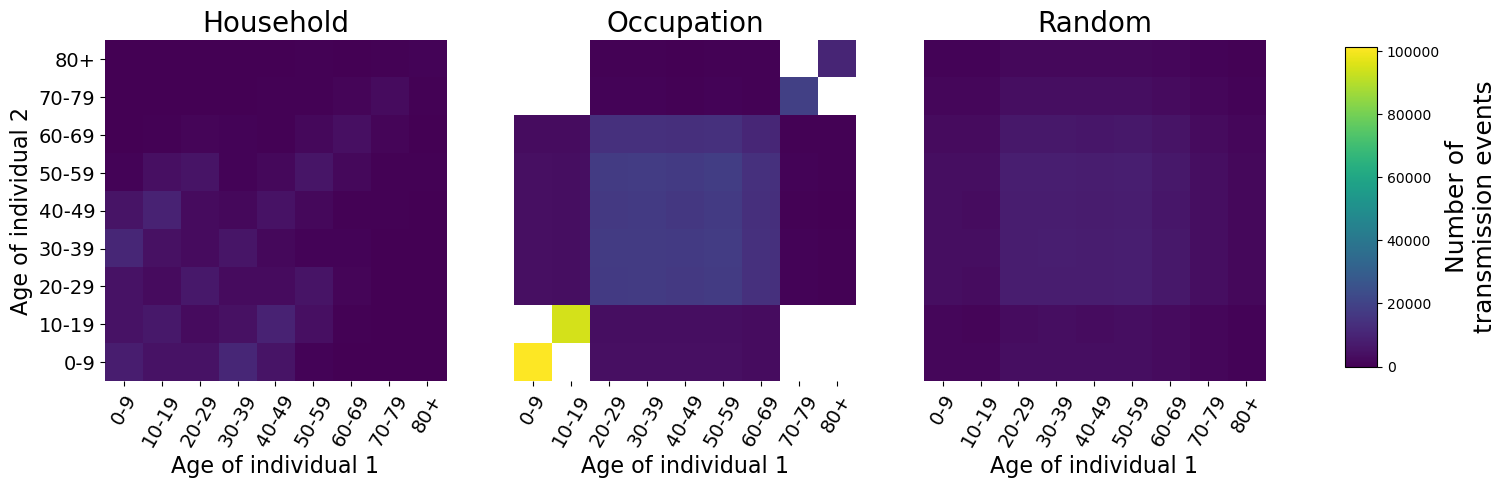

In [17]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plotting.transmission_heatmap_by_age_by_panels(
    df_interact, "age_group_1", "age_group_2", bins = n_age, 
    panelvar = "type", panel_labels = interaction_labels,
    xlabel = "Age of individual 1", ylabel = "Age of individual 2", 
    legend_title = "Number of\ntransmission events",
    xticklabels = age_group_labels, yticklabels = age_group_labels)

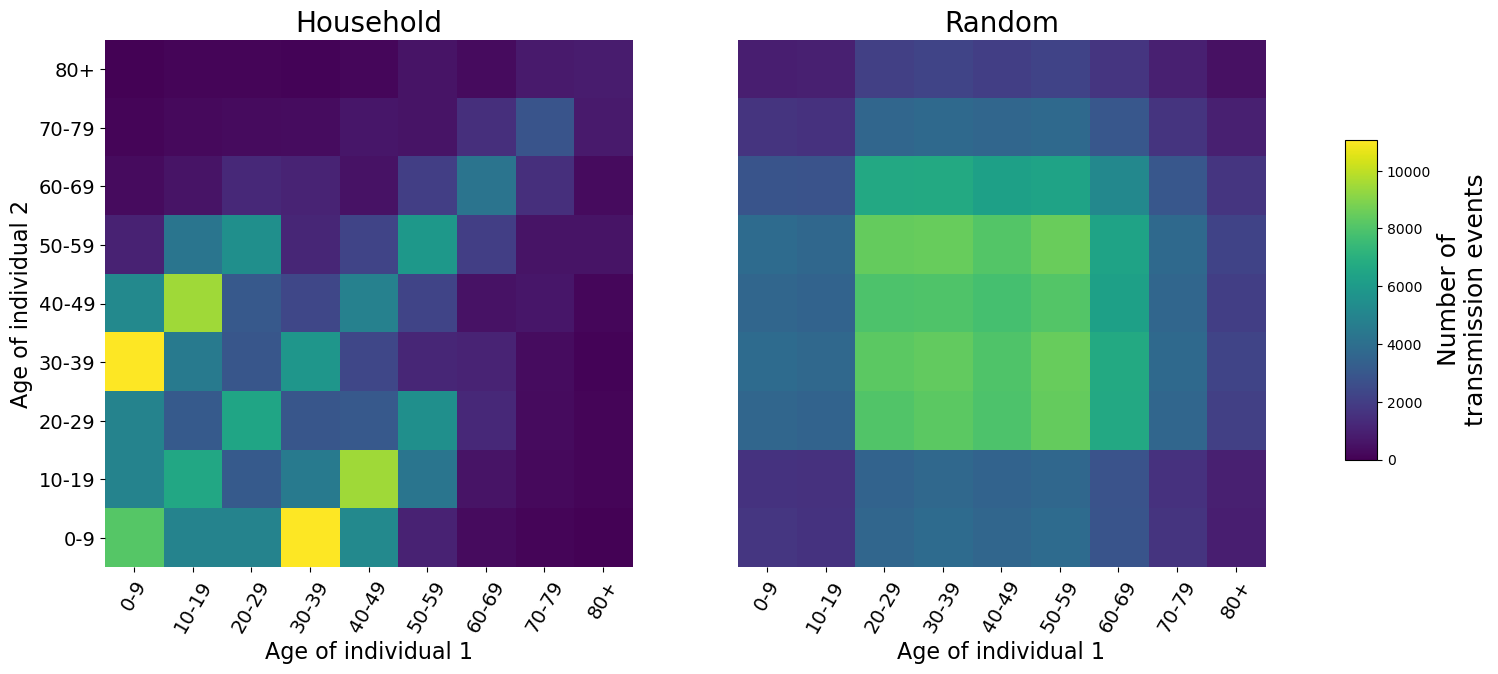

In [18]:
interaction_types_not_occ = [c.value for c in TransmissionTypeEnum if c.name in ["_household", "_random"]]
interaction_labels_not_occ = [c.name[1:].title() for c in TransmissionTypeEnum if c.name in ["_household", "_random"]]

plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plotting.transmission_heatmap_by_age_by_panels(
    df_interact, "age_group_1", "age_group_2", bins = n_age, 
    panels = interaction_types_not_occ,
    panelvar = "type", panel_labels = interaction_labels_not_occ,
    xlabel = "Age of individual 1", ylabel = "Age of individual 2", 
    legend_title = "Number of\ntransmission events",
    xticklabels = age_group_labels, yticklabels = age_group_labels)

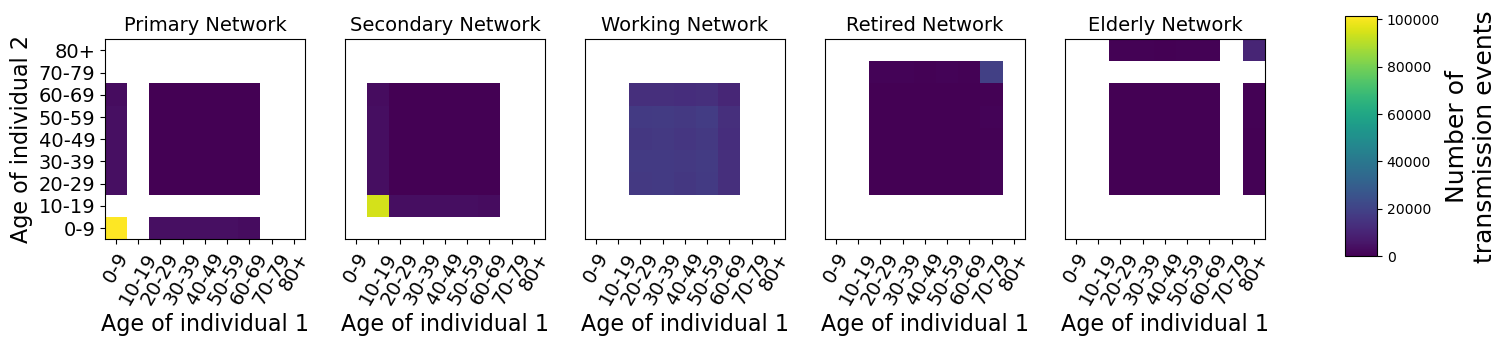

In [19]:
occupation_value = [c.value for c in TransmissionTypeEnum if c.name == "_occupation"]
df_interact_occupation = df_interact[df_interact.type == occupation_value[0]]

plt.rcParams['figure.figsize'] = [16, 6]
fig, ax = plotting.transmission_heatmap_by_age_by_panels(
    df_interact_occupation, "age_group_1", "age_group_2", bins = n_age, 
    panels = occupation_types,
    panelvar = "occupation_network_1", panel_labels = occupation_labels,
    xlabel = "Age of individual 1", ylabel = "Age of individual 2", 
    legend_title = "Number of\ntransmission events",
    xticklabels = age_group_labels, yticklabels = age_group_labels, 
    title_fontsize = 14, spines = True)

# Transmission network <a class="anchor" id="transmission-network"></a>
[[Home](#home)]

### Proportion and number of transmission stratified by infectious status of source

In [20]:
# Remove seed cases
df_trans = df_trans[df_trans["status_source"] != EVENT_TYPES.SUSCEPTIBLE.value]

# Calculate count and percent transmissions by disease status of the source
count_trans_status_source = df_trans["status_source"].value_counts().reset_index()
count_trans_status_source.columns = ["status_source", "Number of transmission events"]
count_trans_status_source["Percent of all transmission events"] = 100*count_trans_status_source["Number of transmission events"]/df_trans.shape[0]

count_trans_status_source["Source status"] = count_trans_status_source.status_source.map(lambda x: plotting.EVENT_TYPE_STRING[EVENT_TYPES(x).value])

# Add totals
count_trans_status_source = count_trans_status_source.append(count_trans_status_source.sum(numeric_only = True), ignore_index = True)
count_trans_status_source.loc[count_trans_status_source.shape[0]-1, ["Source status"]] = "Total"

display(count_trans_status_source[count_trans_status_source["Percent of all transmission events"] > 0][["Number of transmission events", "Percent of all transmission events", "Source status"]].style.hide_index().set_precision(2))

Number of transmission events,Percent of all transmission events,Source status
31655.00,36.78,Presymptomatic (mild)
25940.00,30.14,Symptomatic (mild)
15145.00,17.60,Asymptomatic
7430.00,8.63,Presymptomatic (severe)
5895.00,6.85,Symptomatic (severe)
86065.00,100.00,Total


### Transmission events stratified by age of recipient/source and infectious status of source

In [21]:
for age_var in ["age_group_recipient", "age_group_source"]:
    label = age_var.replace("_", " ").capitalize()
    interactions = pd.pivot_table(df_trans, index = age_var, columns = "status_source", 
        aggfunc = 'size', fill_value = 0)
    interactions.columns = infectious_labels
    interactions[label] = age_group_labels
    display(interactions[[label] + infectious_labels].style.hide_index())

Age group recipient,Presymptomatic (severe),Presymptomatic (mild),Asymptomatic,Symptomatic (severe),Symptomatic (mild)
0-9,328,2641,1708,314,2413
10-19,502,3878,2027,401,3170
20-29,977,4500,2060,811,3599
30-39,1021,4543,2092,800,3632
40-49,986,4452,2045,761,3498
50-59,1068,4588,2062,870,3720
60-69,961,3594,1606,707,3011
70-79,960,2243,975,744,1812
80+,627,1216,570,487,1085


Age group source,Presymptomatic (severe),Presymptomatic (mild),Asymptomatic,Symptomatic (severe),Symptomatic (mild)
0-9,56,1842,1475,49,1480
10-19,160,3531,2064,110,2791
20-29,341,4952,2720,270,4304
30-39,524,4827,2528,474,3950
40-49,1008,5305,2235,766,4097
50-59,1568,5171,1821,1188,4010
60-69,1841,3650,1388,1497,3253
70-79,1139,1545,589,910,1284
80+,793,832,325,631,771


### Transmission events stratified by age of recipient and source and infectious status of source

In [22]:
for i, t in enumerate(infectious_types):
    transmissions = pd.pivot_table(df_trans.loc[df_trans.status_source == t], 
        index = "age_group_recipient", columns = "age_group_source", aggfunc = 'size', fill_value = 0)
    transmissions.columns = age_group_labels
    transmissions["Age group"] = age_group_labels
    
    display(HTML("<hr>"))
    display(HTML("Transmission events from source that is <b>{}</b>".format(infectious_labels[i])))
    display(HTML("Rows: Age of recipient <br>Columns: Age of source"))
    display(transmissions[["Age group"] + age_group_labels].style.hide_index().set_precision(0))

Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,30,7,25,55,56,65,52,23,15
10-19,2,99,22,43,118,99,72,25,22
20-29,7,8,50,66,145,278,301,70,52
30-39,7,11,53,107,158,242,300,85,58
40-49,3,16,46,75,165,256,276,92,57
50-59,2,11,71,72,166,283,330,90,43
60-69,4,6,51,70,120,221,310,107,72
70-79,0,1,16,29,49,73,130,596,66
80+,1,1,7,7,31,51,70,51,408


Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,1028,152,304,502,317,180,120,20,18
10-19,86,1948,325,338,577,400,157,32,15
20-29,154,217,897,735,851,942,546,99,59
30-39,217,294,822,869,806,770,604,95,66
40-49,133,395,773,741,937,769,517,128,59
50-59,109,276,891,706,819,993,629,104,61
60-69,64,152,595,598,627,703,673,123,59
70-79,35,62,239,214,235,252,283,848,75
80+,16,35,106,124,136,162,121,96,420


Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,834,109,188,279,163,60,46,19,10
10-19,58,1136,172,178,266,130,67,12,8
20-29,114,131,470,406,320,305,249,43,22
30-39,184,187,433,438,338,270,187,36,19
40-49,95,228,440,352,381,279,210,46,14
50-59,80,151,486,381,314,358,243,27,22
60-69,65,65,329,322,265,248,244,50,18
70-79,27,42,129,104,119,102,98,324,30
80+,18,15,73,68,69,69,44,32,182


Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,28,2,29,63,45,57,51,25,14
10-19,2,65,10,26,77,83,86,35,17
20-29,1,8,40,74,122,205,253,67,41
30-39,9,9,47,89,112,200,228,62,44
40-49,3,13,41,74,118,176,203,73,60
50-59,1,5,40,67,129,220,262,83,63
60-69,4,5,39,47,89,143,254,85,41
70-79,0,2,14,24,45,60,120,434,45
80+,1,1,10,10,29,44,40,46,306


Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,869,120,317,426,311,167,150,32,21
10-19,52,1631,255,267,455,293,165,35,17
20-29,99,153,741,635,633,692,510,80,56
30-39,157,184,682,693,647,588,507,114,60
40-49,97,319,633,542,663,602,492,92,58
50-59,85,198,781,578,590,784,530,104,70
60-69,77,101,571,518,484,535,550,129,46
70-79,22,60,198,175,200,215,245,644,53
80+,22,25,126,116,114,134,104,54,390


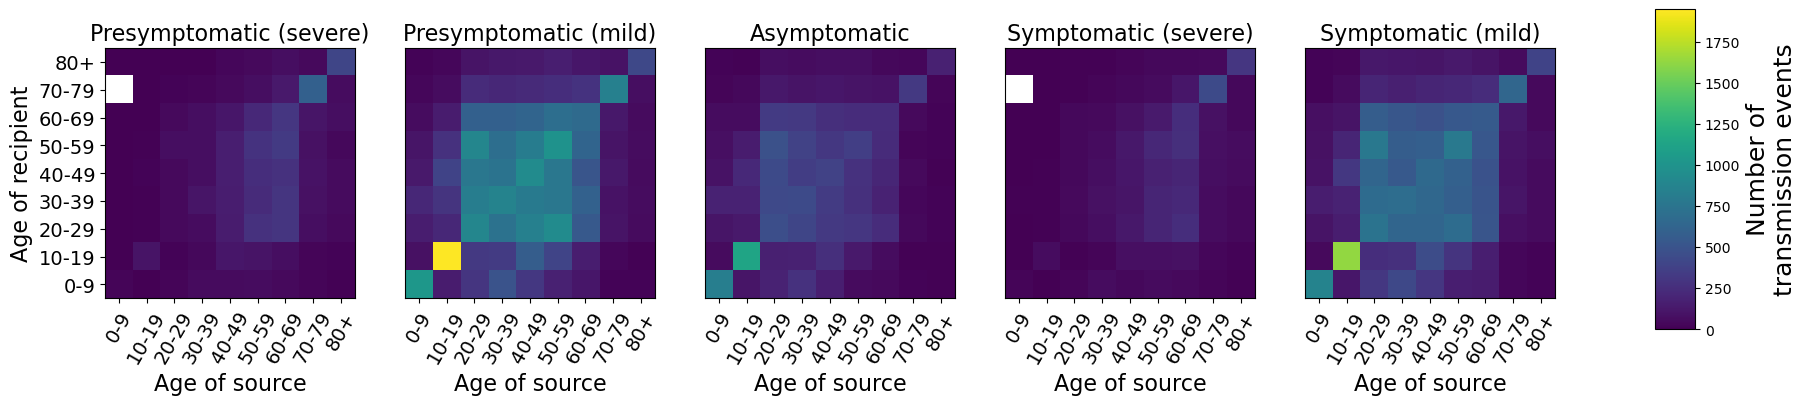

In [23]:
plt.rcParams['figure.figsize'] = [20, 8]
fig, ax = plotting.transmission_heatmap_by_age_by_panels(
    df_trans, "age_group_recipient", "age_group_source", bins = n_age, 
    panelvar = "status_source", panel_labels = infectious_labels,
    xlabel = "Age of source", ylabel = "Age of recipient", 
    legend_title = "Number of\ntransmission events",
    xticklabels = age_group_labels, yticklabels = age_group_labels, 
    title_fontsize = 16, spines = True)

### Generation time by infection status of source (stacked)

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


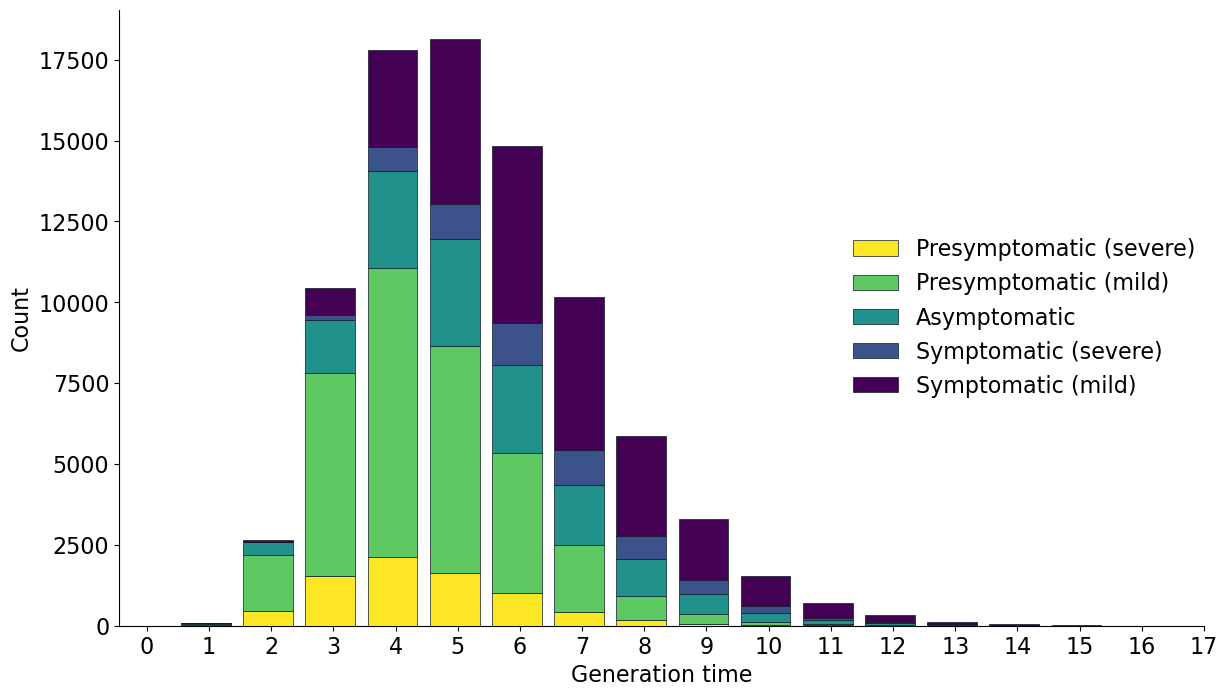

In [24]:
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plotting.plot_stacked_hist_by_group(df_trans, 
    groupvar = "status_source", binvar = "generation_time", 
    groups = infectious_types,
    NBINS = 18, group_labels = infectious_labels,
    xlabel = "Generation time", ylabel = "Count")

### Generation time by infection status of source (unstacked)

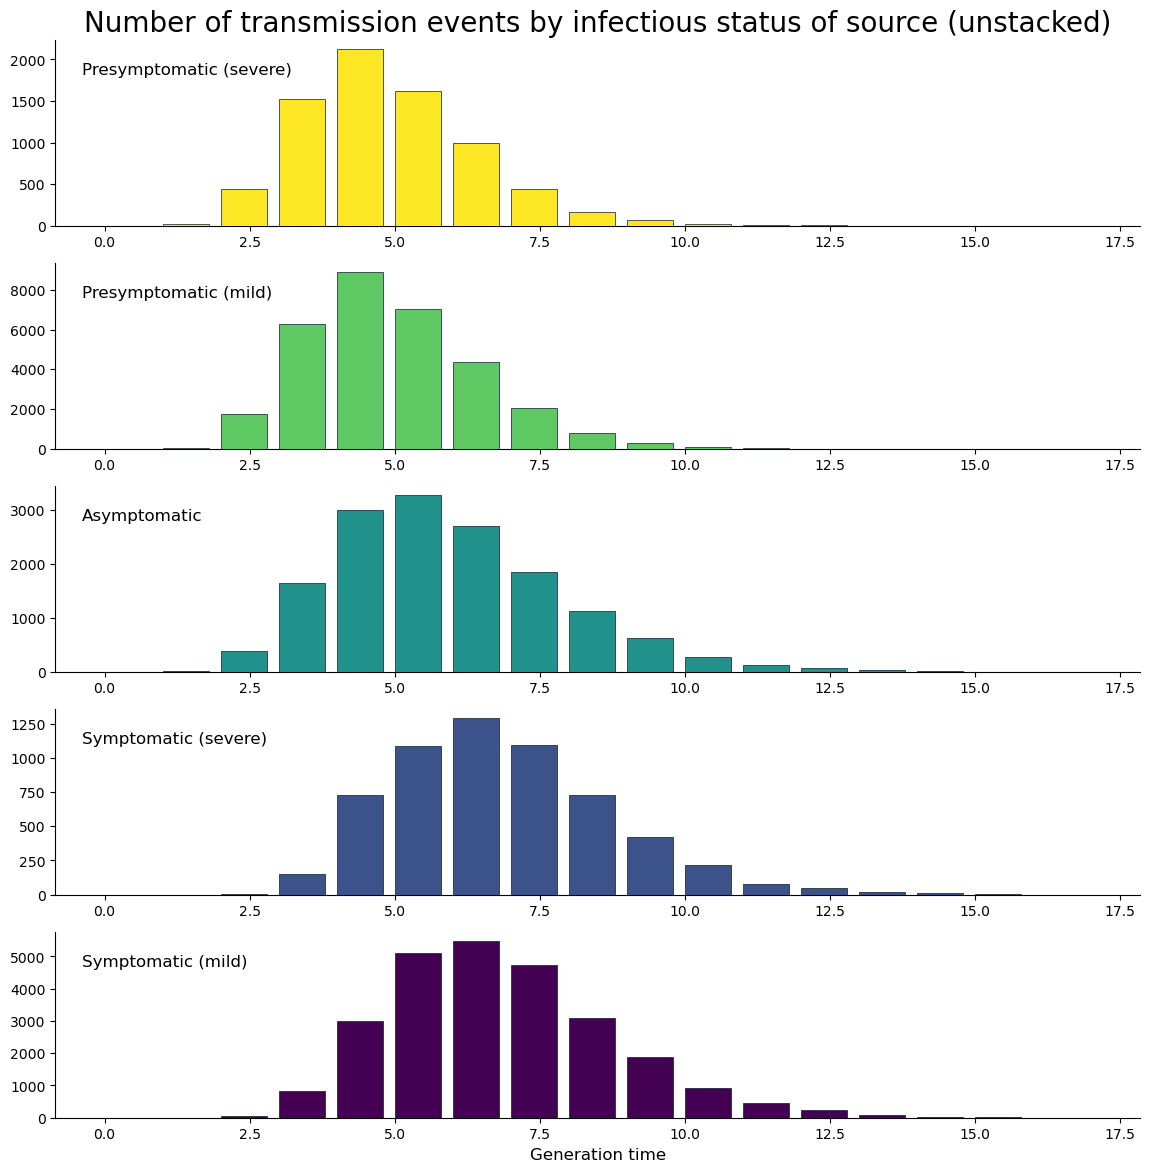

In [25]:
n_groups = len(infectious_types)
colours = plotting.get_discrete_viridis_colours(n_groups)
NBINS = 18
plt.rcParams['figure.figsize'] = [14,14]
fig, ax = plt.subplots(nrows = n_groups)
for i, state in enumerate(infectious_types):
    hist = df_trans.loc[df_trans["status_source"] == state]["generation_time"]
    bins = np.arange(NBINS)
    ax[i].hist(hist, bins, color = colours[i], 
               width = 0.8, edgecolor = "#0d1a26", 
               linewidth = 0.5, zorder = 3, 
               label = infectious_labels[i])
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    
    ax[i].text(0.025, 0.8, "{}".format(infectious_labels[i]),
    ha = 'left', va = 'bottom', 
    transform = ax[i].transAxes, fontsize = 12)
    
    if i == (n_groups - 1):
        ax[i].set_xlabel("Generation time", fontsize = 12)
    if i ==0:
        ax[i].set_title("Number of transmission events by infectious status of source (unstacked)", size = 20)

### Transmission events by age of infected individual and location of transmission event

In [26]:
transmissions = pd.pivot_table(df_trans, 
    index = "age_group_recipient", columns = "infector_network", 
    aggfunc = 'size', fill_value = 0)
transmissions.columns = interaction_labels
transmissions["Age group"] = age_group_labels
display(transmissions[["Age group"] + interaction_labels].style.hide_index().set_properties(subset=["Age group"], **{'font-weight': 'bold'}))

Age group,Household,Occupation,Random
0-9,2633,3415,1356
10-19,2841,5570,1567
20-29,2262,6032,3653
30-39,1986,6290,3812
40-49,2151,5967,3624
50-59,2059,6406,3843
60-69,1240,5280,3359
70-79,1169,2561,3004
80+,482,1699,1804


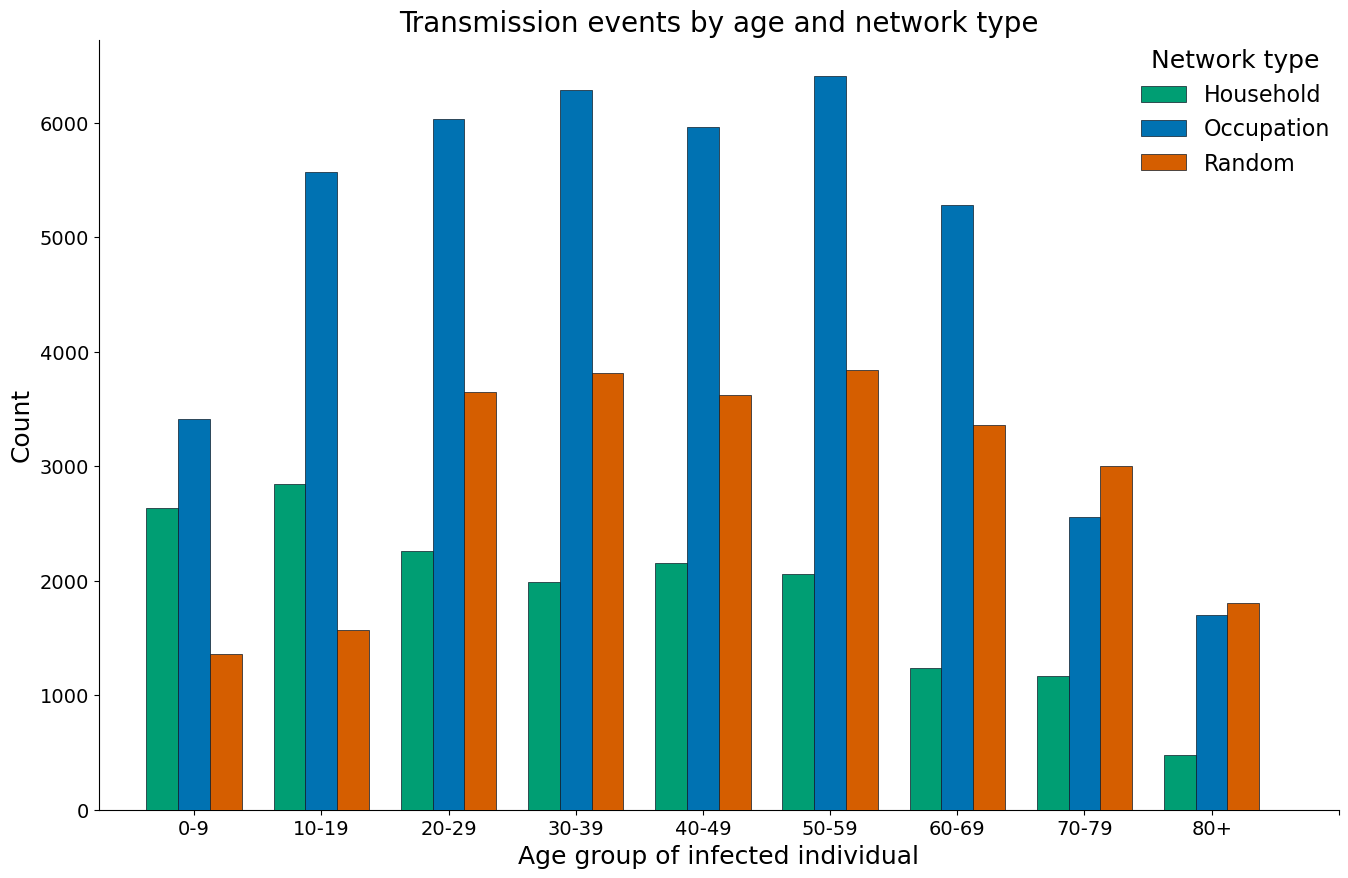

In [27]:
plt.rcParams['figure.figsize'] = [16, 10]
fig, ax = plotting.plot_hist_by_group(df_trans[df_trans.infector_network >= 0], 
    groupvar = "infector_network", binvar = "age_group_recipient", 
    groups = [0, 1, 2], bins = n_age, group_colours = plotting.network_colours,
    group_labels = interaction_labels, 
    xlabel = "Age group of infected individual",ylabel = "Count",
    title = "Transmission events by age and network type",
    legend_title = "Network type", xticklabels = age_group_labels)

### Transmission events stratified by age

In [28]:
transmissions = pd.pivot_table(df_trans, 
    index = "age_group_recipient", 
    columns = "age_group_source", 
    aggfunc = 'size', fill_value = 0)

transmissions.columns = age_group_labels
transmissions["Age group"] = age_group_labels

display(HTML("<b>Transmission events</b>"))
display(HTML("Rows: Age of recipient <br>Columns: Age of source"))
display(transmissions[["Age group"] + age_group_labels].style.hide_index().set_precision(0).set_properties(subset=["Age group"], **{'font-weight': 'bold'}))

Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,2789,390,863,1325,892,529,419,119,78
10-19,200,4879,784,852,1493,1005,547,139,79
20-29,375,517,2198,1916,2071,2422,1859,359,230
30-39,574,685,2037,2196,2061,2070,1826,392,247
40-49,331,971,1933,1784,2264,2082,1698,431,248
50-59,277,641,2269,1804,2018,2638,1994,408,259
60-69,214,329,1585,1555,1585,1850,2031,494,236
70-79,84,167,596,546,648,702,876,2846,269
80+,58,77,322,325,379,460,379,279,1706


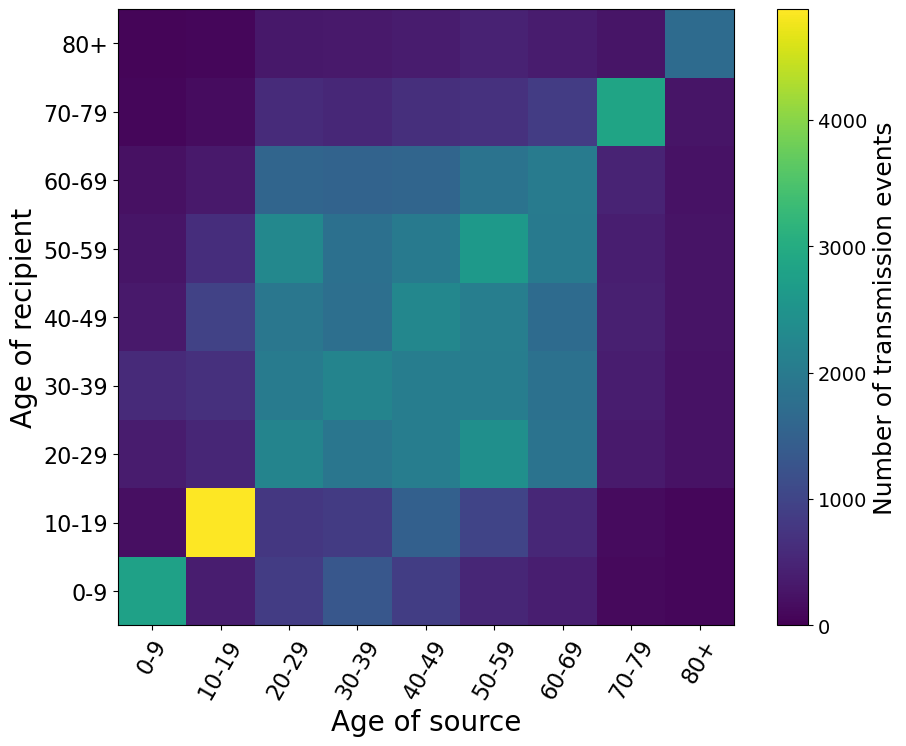

In [29]:
plt.rcParams['figure.figsize'] = [14, 8]

display(HTML("Of all transmission events, the following figure shows the distribution of transmission events (2D histogram)<br> stratified by the age of the source and recipient."))

fig, ax = plotting.plot_transmission_heatmap_by_age(df_trans, "age_group_recipient", "age_group_source", 
    bins = n_age, xlabel = "Age of source", ylabel = "Age of recipient", 
    legend_title = "Number of transmission events",
    xticklabels = age_group_labels, yticklabels = age_group_labels)

### Transmission events stratified by age and network

In [30]:
for i, t in enumerate(interaction_types):
    transmissions = pd.pivot_table(df_trans.loc[df_trans.infector_network == t], 
        index = "age_group_recipient", columns = "age_group_source", aggfunc = 'size', fill_value = 0)
    transmissions.columns = age_group_labels
    transmissions["Age group"] = age_group_labels
    
    display(HTML("<hr>"))
    display(HTML("Transmission events occuring in network <b>{}</b>".format(interaction_labels[t])))
    display(HTML("Rows: Age of recipient <br>Columns: Age of source"))
    display(transmissions[["Age group"] + age_group_labels].style.hide_index().set_precision(0).set_properties(subset=["Age group"], **{'font-weight': 'bold'}))

Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,324,321,433,949,465,90,35,11,5
10-19,156,423,295,408,1014,440,65,21,19
20-29,151,203,566,270,319,560,148,30,15
30-39,334,312,285,540,239,119,122,24,11
40-49,141,619,269,224,517,225,68,67,21
50-59,25,274,455,116,217,611,255,52,54
60-69,11,32,108,96,57,207,553,144,32
70-79,7,28,31,54,86,90,302,445,126
80+,1,13,19,10,27,92,40,133,147


Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,2421,0,225,164,198,231,176,0,0
10-19,0,4378,227,214,248,279,224,0,0
20-29,129,159,1042,1108,1144,1230,1103,68,49
30-39,148,182,1128,1104,1208,1293,1100,72,55
40-49,102,197,1082,1020,1183,1203,1057,78,45
50-59,144,188,1195,1142,1161,1324,1130,73,49
60-69,117,160,931,955,1009,1052,933,84,39
70-79,0,0,91,70,71,83,70,2176,0
80+,0,0,38,57,60,35,51,0,1458


Age group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0-9,44,69,205,212,229,208,208,108,73
10-19,44,78,262,230,231,286,258,118,60
20-29,95,155,590,538,608,632,608,261,166
30-39,92,191,624,552,614,658,604,296,181
40-49,88,155,582,540,564,654,573,286,182
50-59,108,179,619,546,640,703,609,283,156
60-69,86,137,546,504,519,591,545,266,165
70-79,77,139,474,422,491,529,504,225,143
80+,57,64,265,258,292,333,288,146,101


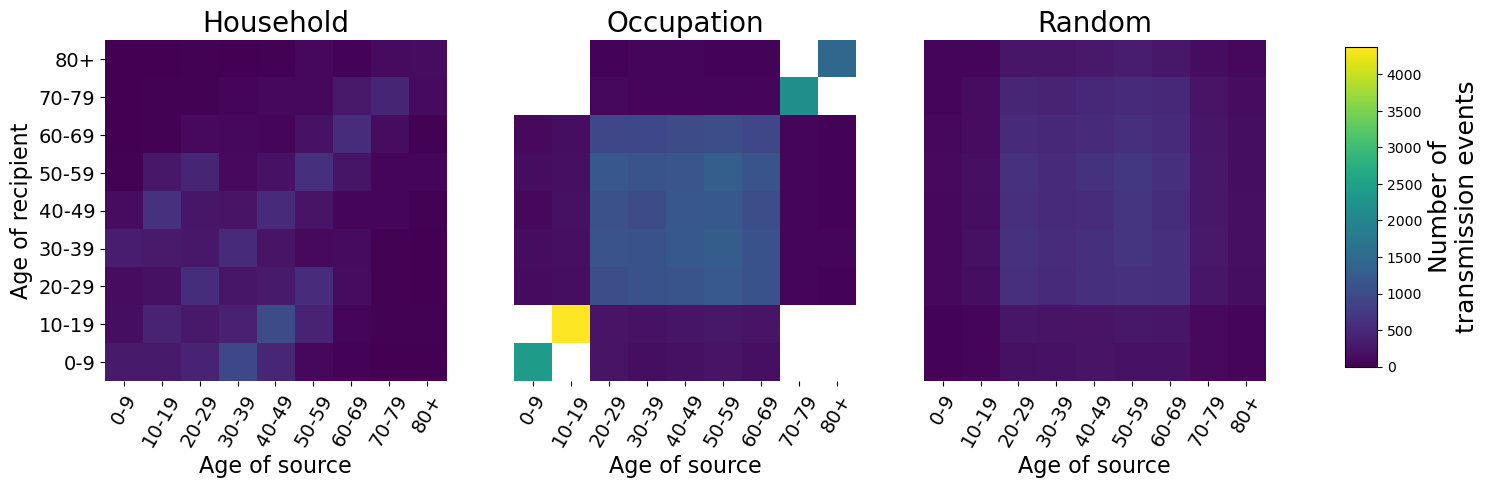

In [31]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plotting.transmission_heatmap_by_age_by_panels(
    df_trans, "age_group_recipient", "age_group_source", bins = n_age, 
    panelvar = "infector_network", panel_labels = interaction_labels,
    xlabel = "Age of source", ylabel = "Age of recipient", 
    legend_title = "Number of\ntransmission events",
    xticklabels = age_group_labels, yticklabels = age_group_labels)

# Age-stratified outputs <a class="anchor" id="age-stratified-outputs"></a>

States that an individual may be in, stratified by age (of all individuals ever in such a state in the simulation).  

[[Home](#home)]

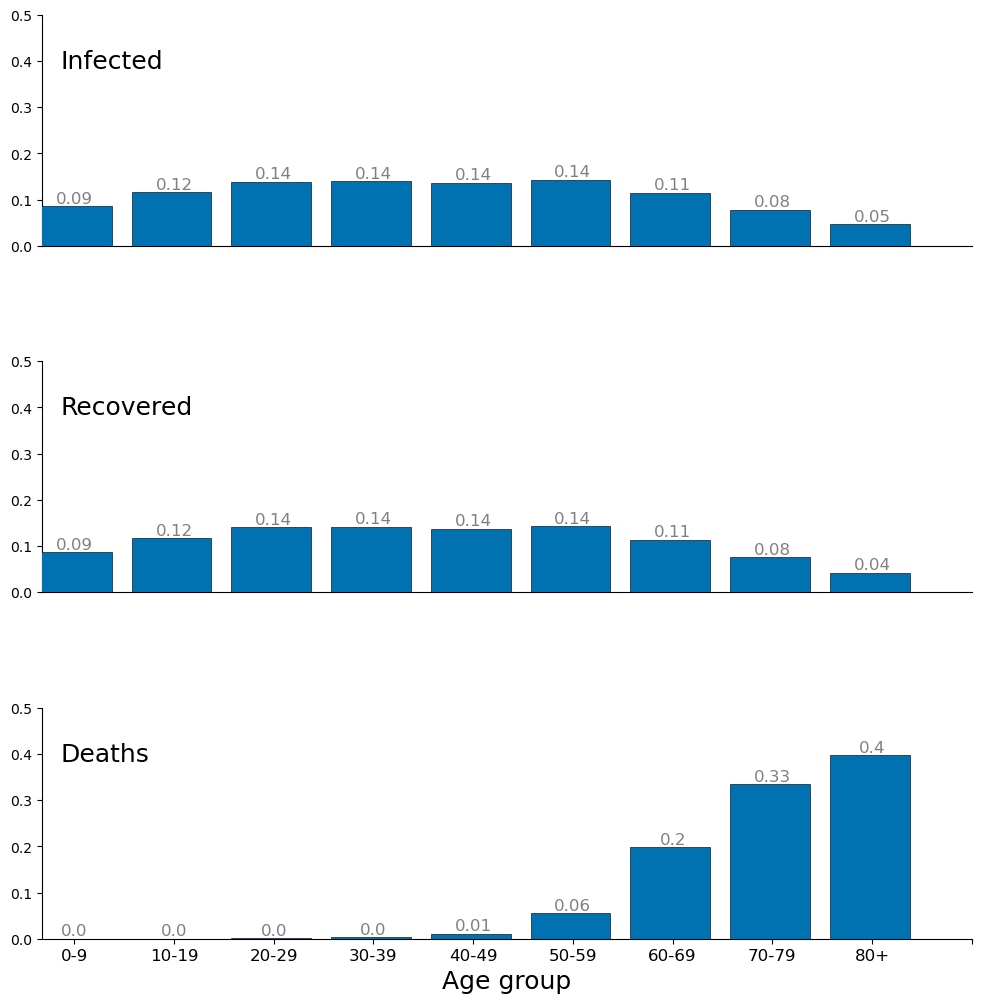

In [32]:
plt.rcParams['figure.figsize'] = [12, 12]
groupvars = ["time_infected", "time_recovered", "time_death"]
labels = ["Infected", "Recovered", "Deaths"]
fig, ax = plotting.PlotHistByAge(df_trans, groupvars = groupvars, group_labels = labels,
    NBINS = n_age -1 , density = True, xticklabels = age_group_labels, xlabel = "Age group",
    ylim = 0.5, age_group_var = "age_group_recipient")

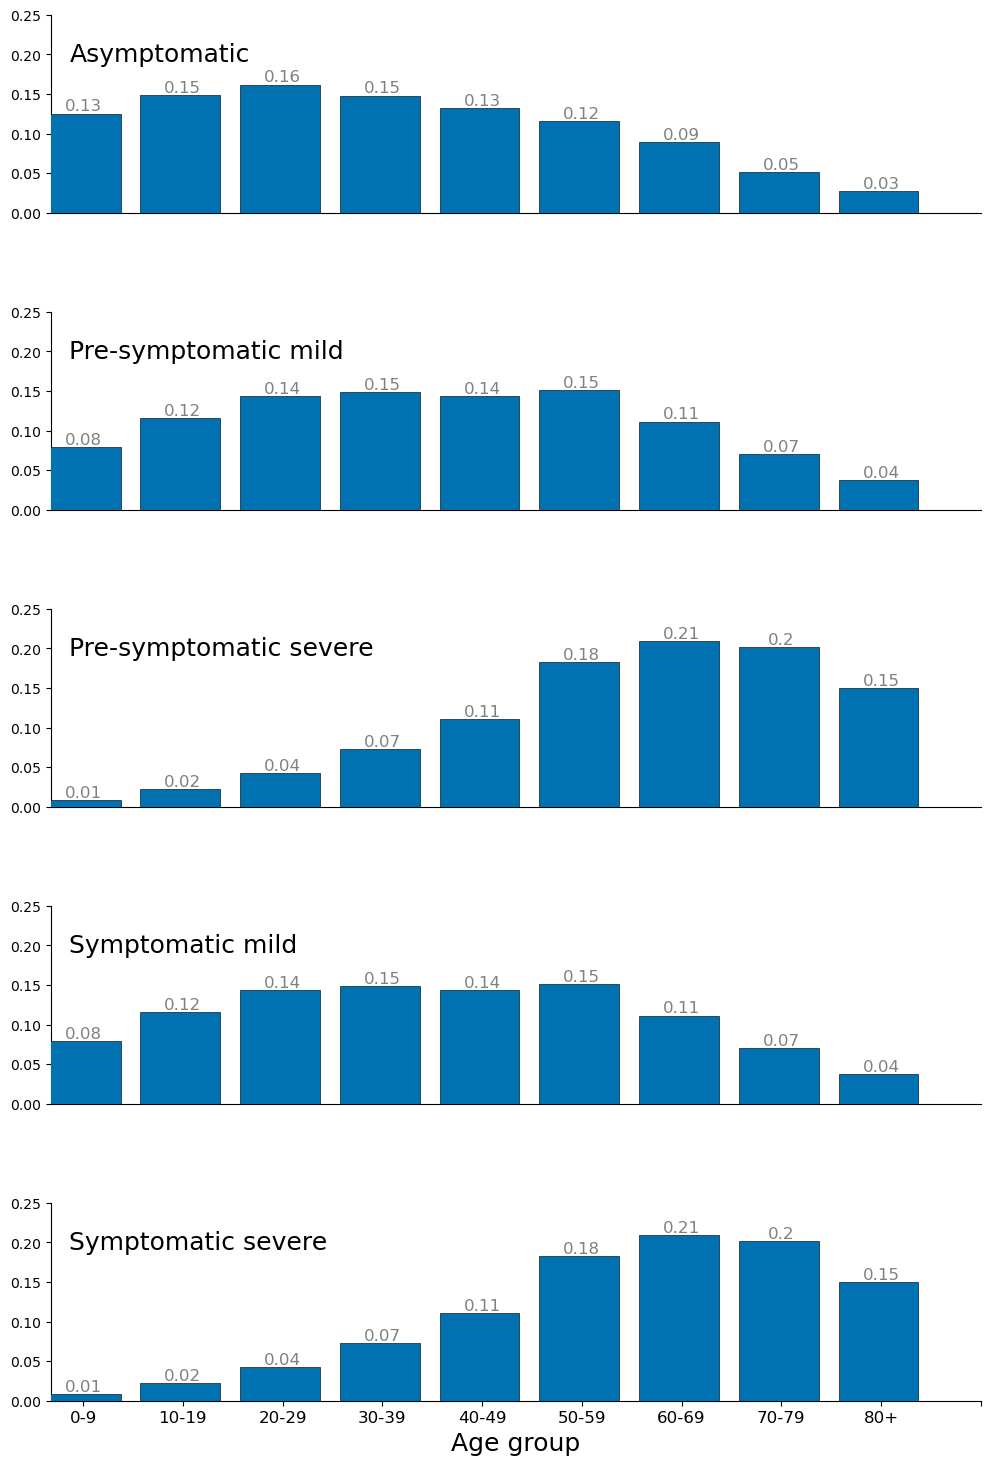

In [33]:
plt.rcParams['figure.figsize'] = [12, 18]
groupvars = ["time_asymptomatic", "time_presymptomatic_mild", 
    "time_presymptomatic_severe", "time_symptomatic_mild", 
    "time_symptomatic_severe"]

labels = ["Asymptomatic", "Pre-symptomatic mild", 
    "Pre-symptomatic severe", "Symptomatic mild", 
    "Symptomatic severe"]

fig, ax = plotting.PlotHistByAge(df_trans, groupvars = groupvars, group_labels = labels,
    NBINS = n_age -1 , density = True, xticklabels = age_group_labels, xlabel = "Age group",
    ylim = 0.25, age_group_var = "age_group_recipient")

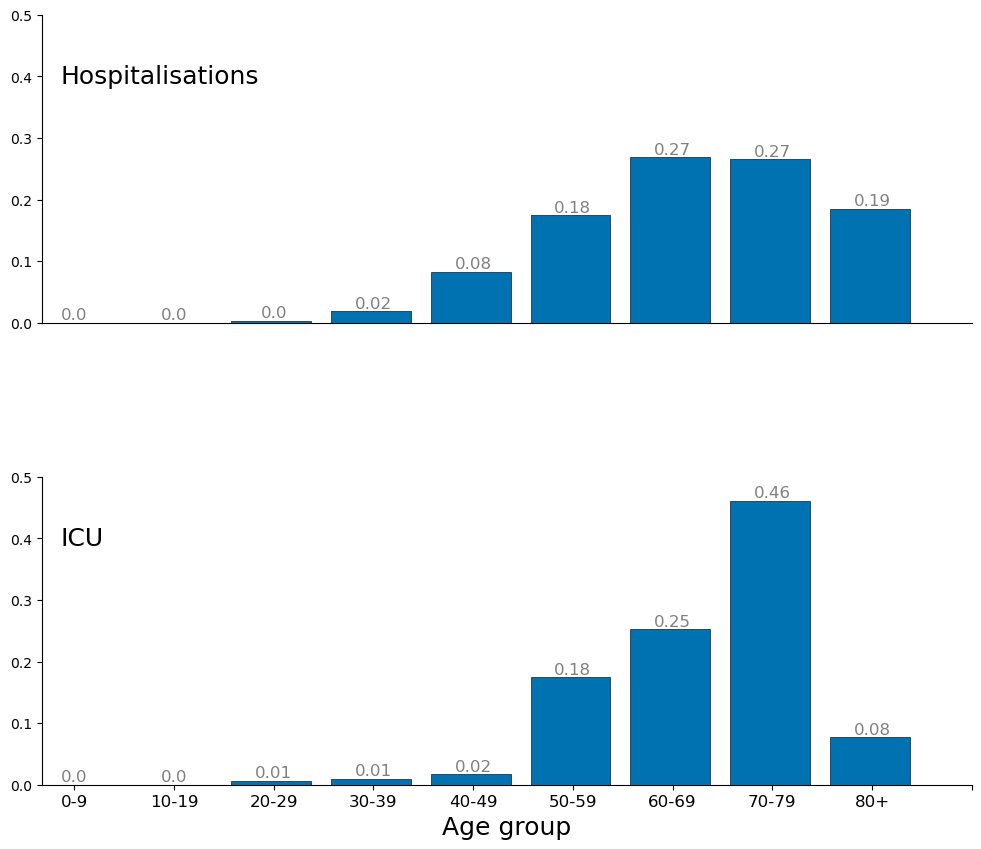

In [34]:
plt.rcParams['figure.figsize'] = [12, 10]
groupvars = ["time_hospitalised", "time_critical"]
labels = ["Hospitalisations", "ICU"]

fig, ax = plotting.PlotHistByAge(df_trans, groupvars = groupvars, group_labels = labels,
    NBINS = n_age -1 , density = True, xticklabels = age_group_labels, xlabel = "Age group",
    ylim = 0.5, age_group_var = "age_group_recipient")

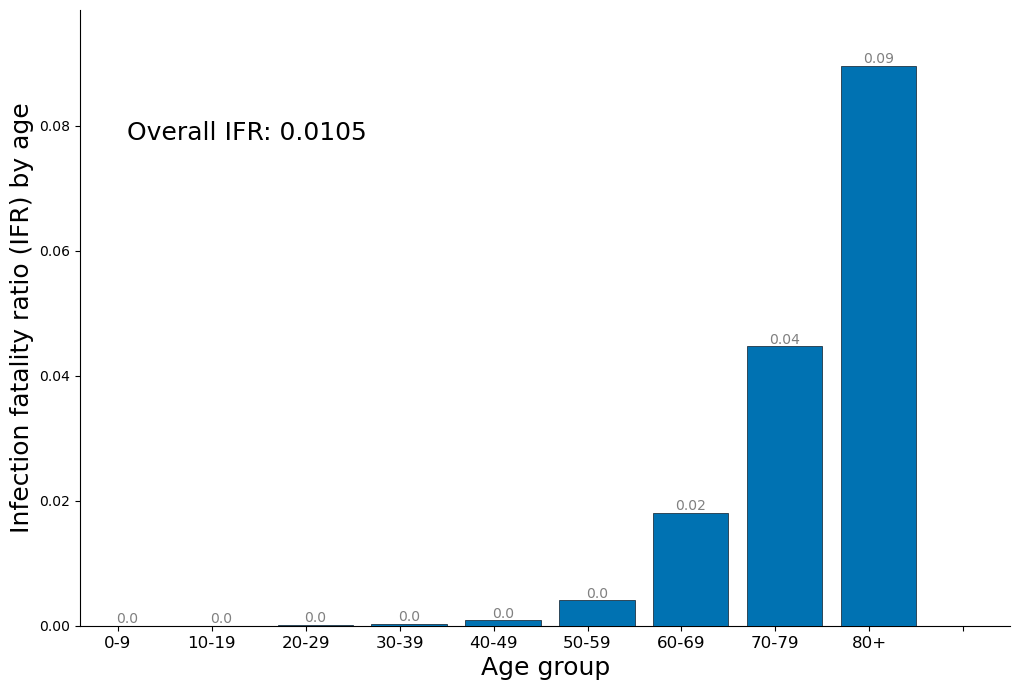

In [35]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plotting.PlotHistIFRByAge(df_trans, "time_death", "time_infected", NBINS = n_age -1, 
    xticklabels = age_group_labels, xlabel = "Age group", age_group_var = "age_group_recipient")